In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-potability/water_potability.csv


In [2]:
# Required Functions
def show_distributions(columns: list, data: pd.DataFrame, nrows: int = 1, ncols: int = 3):
    # This function creates distribution subplots.
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    axes = axes.ravel()
    for index, column in enumerate(columns):
        sns.histplot(data[column], kde=True, ax=axes[index])
        axes[index].set_title(column)

        # Adjust layout
    plt.tight_layout()
    plt.show()
    
def show_boxplots(columns: list, data: pd.DataFrame, nrows: int = 3, ncols: int = 3):
    # This function creates box plot subplots.
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))
    axes = axes.ravel()
    for index, column in enumerate(columns):
        axes[index].boxplot(data[column])
        axes[index].set_title(column)

    plt.tight_layout()
    plt.show()

def normality_test(columns: list, data: pd.DataFrame):
    # Conducts Shapiro-Wilk test.
    for i in columns:
        results = shapiro(data[data[i].isna() == False][i]) 
        print(i, results.statistic)

def random_sample_imputation(df):
    # Random Sample Imputatuin
    cols_with_missing_values = df.columns[df.isna().any()].tolist()

    for var in cols_with_missing_values:

        random_sample_df = df[var].dropna().sample(df[var].isnull().sum(),
                                                      random_state=0)
        random_sample_df.index = df[
                df[var].isnull()].index

        df.loc[df[var].isnull(), var] = random_sample_df

    return df

def visualize_isolation_forest(columns: list, data: pd.DataFrame, contamination: list,nrows: int = 2, ncols: int = 3,):
    # Visualize resuls from different contamination values
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    axes = axes.ravel()
    for index, i in enumerate(contamination):
        model = IsolationForest(contamination=i)  # Adjust the contamination parameter
        model.fit(data.to_numpy())
        sns.scatterplot(data = data[model.predict(data.to_numpy()) == -1], x = columns[0], y = columns[1], color='blue', label='Outlier', ax = axes[index])
        sns.scatterplot(data = data[model.predict(data.to_numpy()) == 1], x = columns[0], y = columns[1], color='red', label='Normal', ax = axes[index])
        axes[index].legend()
        axes[index].set_title(f"Contamination Value: {round(i,3)}")
    plt.show()

def remove_outliers(data: pd.DataFrame, contamination: int):
    # Apply Isolation Forest
    model = IsolationForest(contamination = contamination)
    model.fit(data.to_numpy())
    return data[model.predict(data.to_numpy()) == 1]

def roc_plot(models: list, X_test: pd.DataFrame, y_test: pd.DataFrame):
    # Create ROC plot for multiple models.]
    plt.figure(figsize=(20,10))
    ns_probs = [0 for _ in range(len(X_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    for model in models:
        lr_probs = model.predict_proba(X_test)
        lr_probs = lr_probs[:, 1]
        lr_auc = roc_auc_score(y_test, lr_probs)
        lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
        plt.plot(lr_fpr, lr_tpr, marker='.', label = model["classifier"])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()    
    plt.show()

def forest_feature_importance(model,X_test):
    # Visualize Random Forest Feature Importance
    feature_names = list(X_test.columns)
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

def forest_permutation_importance(model, X_test, y_test, n_repeats:int = 10):
    # Visualize Random Forest Permutation Importance
    feature_names = list(X_test.columns)
    importances = model.feature_importances_
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    result = permutation_importance(
        model, X_test.to_numpy(), y_test, n_repeats=n_repeats, random_state=42, n_jobs=2
    )
    forest_importances = pd.Series(importances, index = feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()




## Descriptive 

In [3]:
data = pd.read_csv("/kaggle/input/water-potability/water_potability.csv")

In [4]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Looking at descriptive statistics. We can see that there are a lot of missing values in "ph", "Sulfate" and "Trihalomethanes".

In [5]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Checking for missing data.

In [6]:
data.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Before dealing with missing data first check for the correlation. From the heat map we can see that there very low correlation between the predictors.

<Axes: >

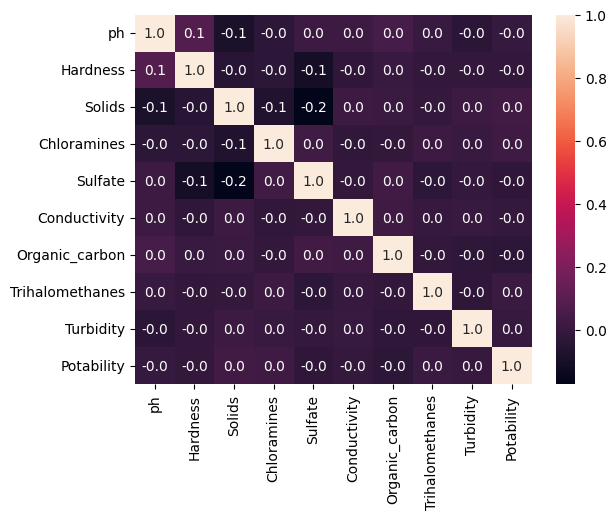

In [7]:
# We don't see any strong correlation between variables
sns.heatmap(data.corr(), annot = True,fmt='.1f') 

We can see that most of the data is close to normal distribution.

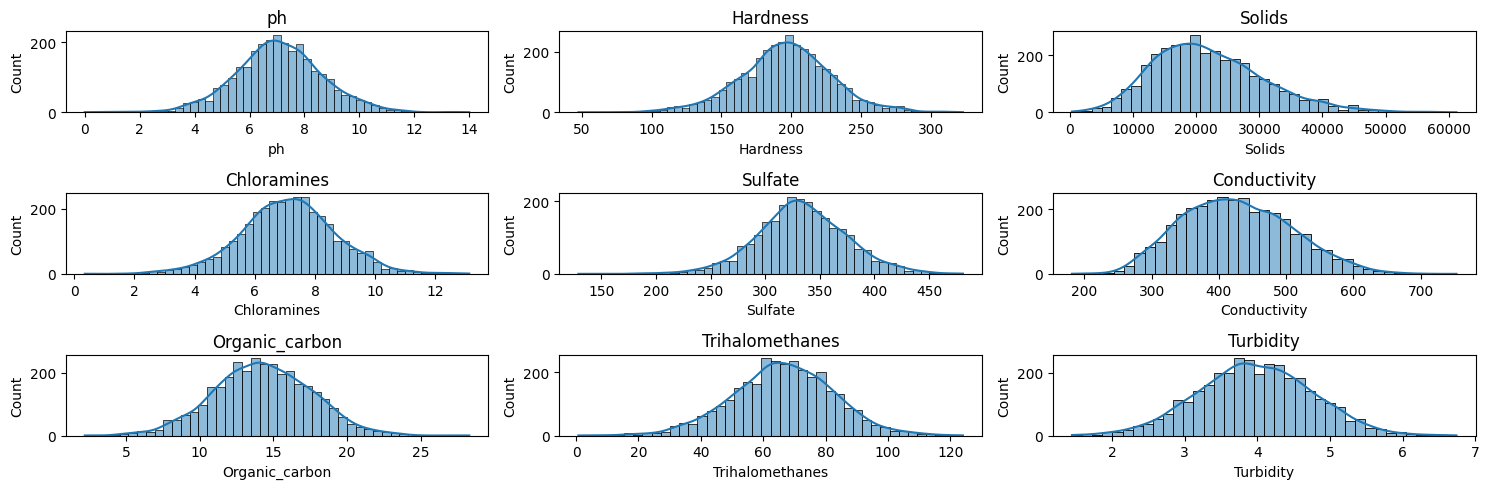

In [8]:
show_distributions(data.columns[:-1], data,3,3)

In [9]:
# Valus of shapiro-wilk test tend to be close to 1 for samples drawn from a normal distribution.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
normality_test(data.columns[:-1], data)


ph 0.9958673715591431
Hardness 0.9959684014320374
Solids 0.9777269959449768
Chloramines 0.996772050857544
Sulfate 0.9960159063339233
Conductivity 0.9929697513580322
Organic_carbon 0.9995209574699402
Trihalomethanes 0.9988604784011841
Turbidity 0.9996957778930664


# Dealing with missing data


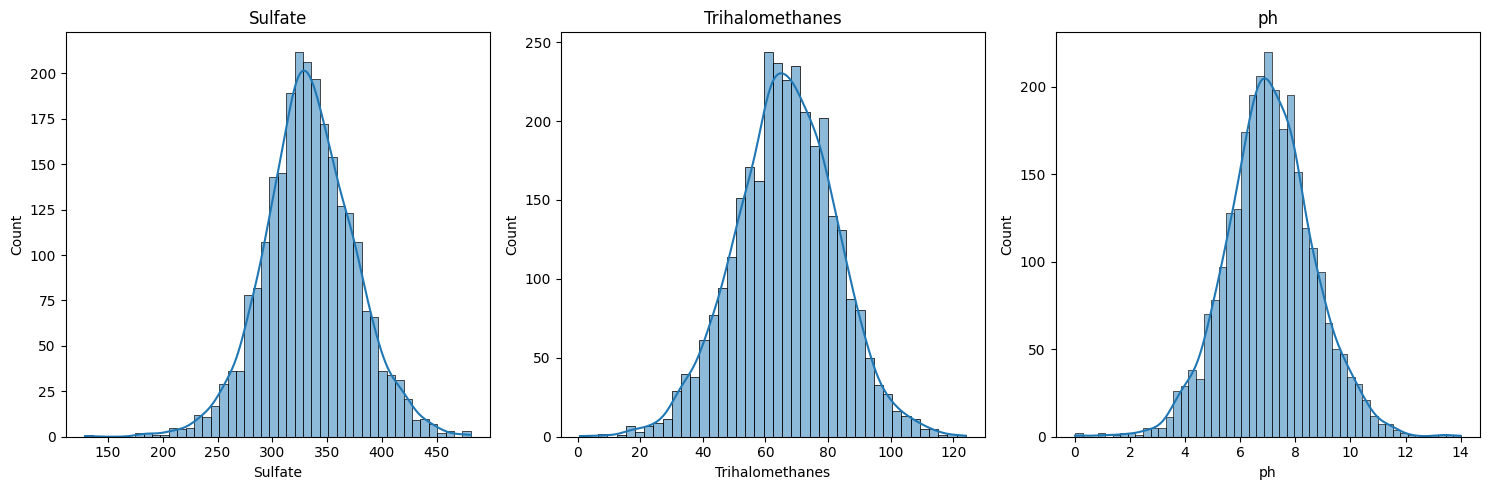

In [10]:
missing_columns = ["Sulfate", "Trihalomethanes", "ph"]
show_distributions(missing_columns, data)

First let mean imputate the data

In [11]:
# Because data is normally disributed we can try to handle missing values with mean values.
# Later we weill also try the performance of model with random smaple imputation.
for i in ["Sulfate", "Trihalomethanes", "ph"]:
    data_mean = data.fillna(data.mean())

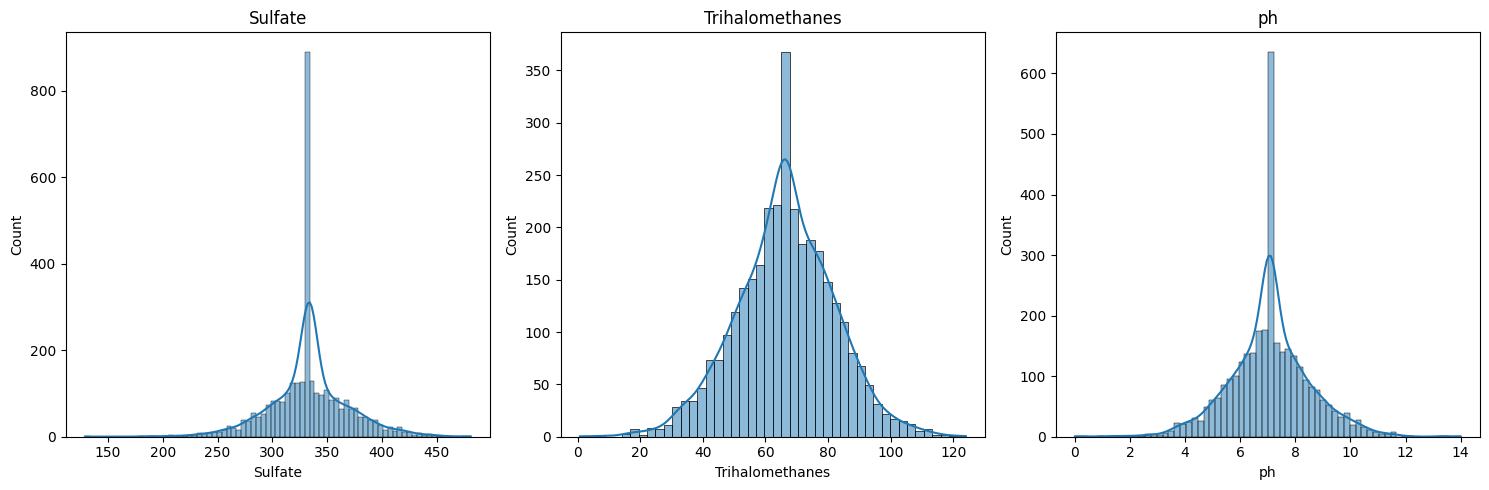

In [12]:
show_distributions(missing_columns, data_mean)

Trying random imputation

In [13]:
data_random = random_sample_imputation(data) 

We can see that if handle missing values at random data is much much nicely distributed.


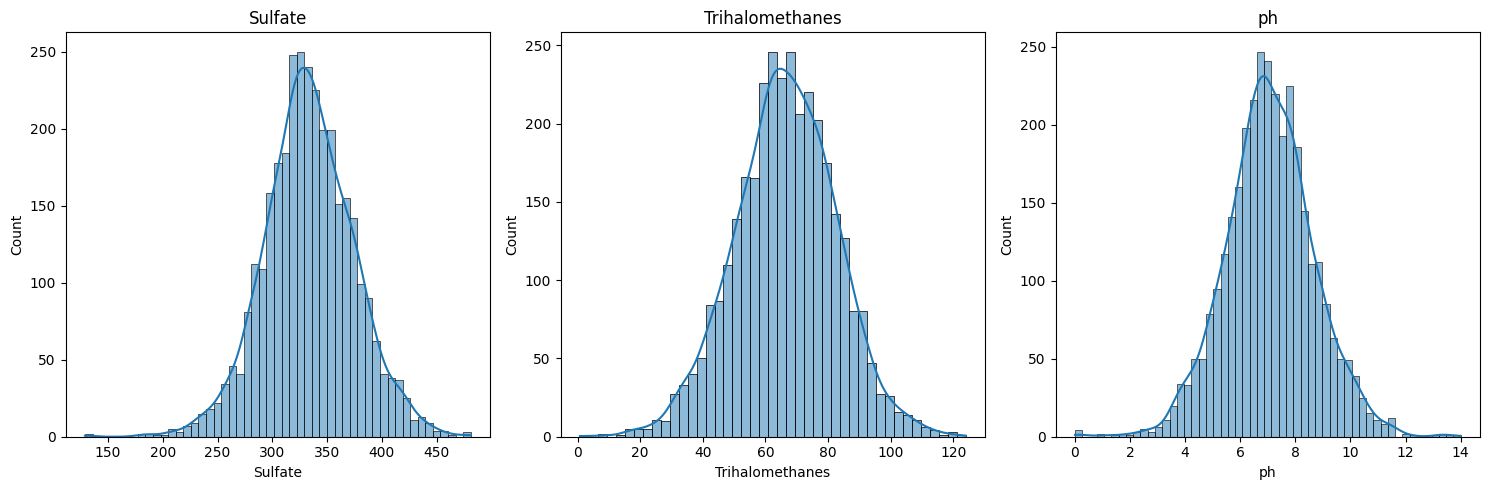

In [14]:
# we can see that if handle missing values at random data is much much nicely distributed.
show_distributions(missing_columns, data_random)

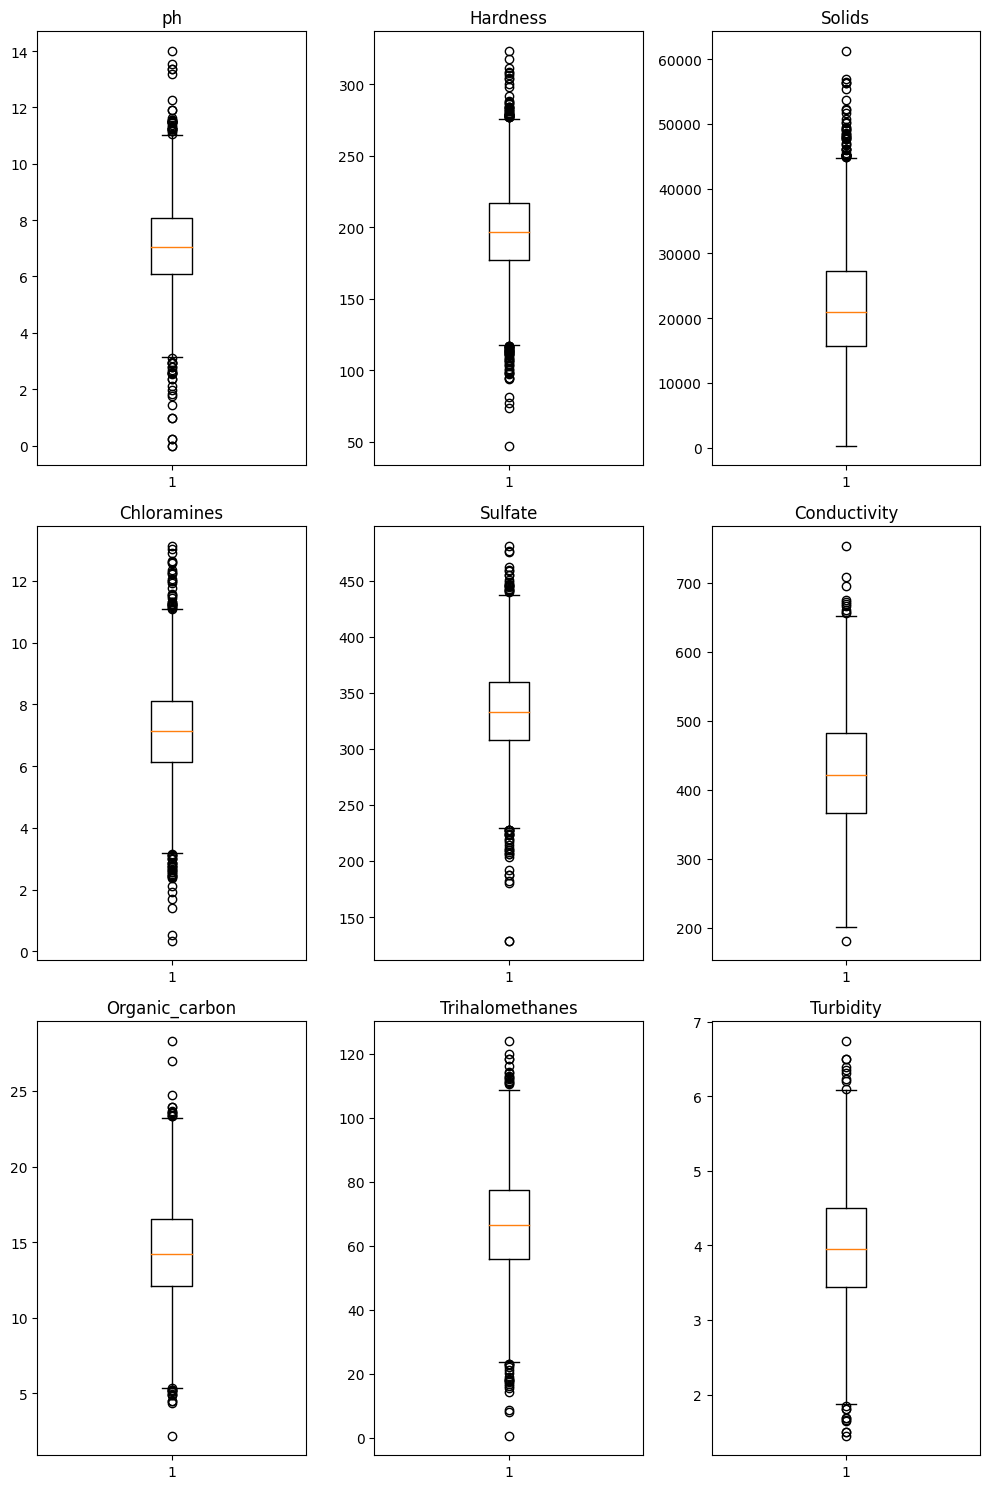

In [15]:
# From boxplots we can see that there a lots of outliers in the data. 
show_boxplots(data_random.columns[:-1], data_random)

# Dealing with Outliars

Visualizing effect of Isolation Forest with different contamination values

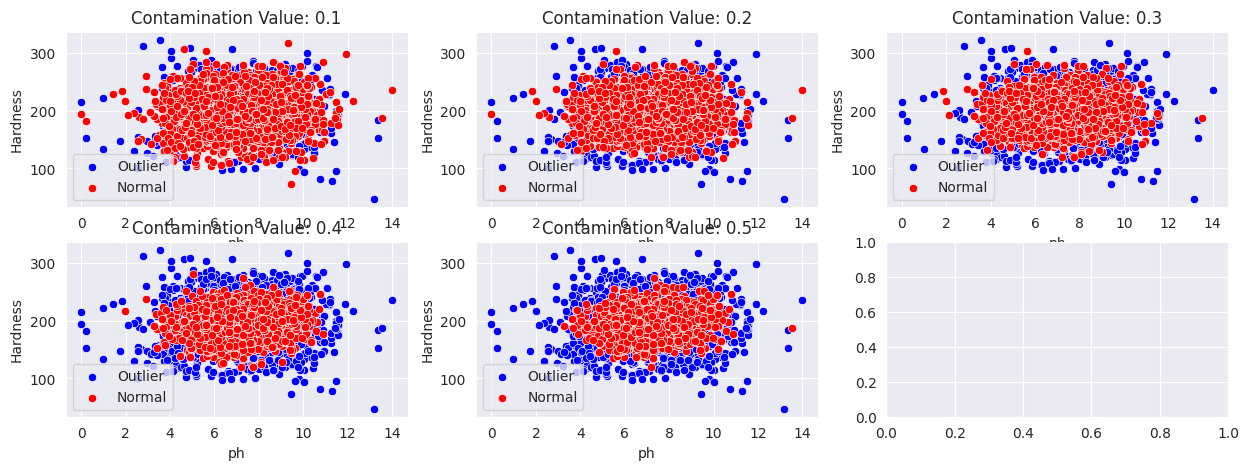

In [16]:
# Using IsolationForest to identify outliers
contamination = np.arange(0.1, 0.6, 0.1)

visualize_isolation_forest(["ph", "Hardness"], data_random,contamination)

Remove outliers using IsolationForest

In [17]:
data_forest = remove_outliers(data_random, 0.3)

Visualize removed and kept values.

<Axes: xlabel='ph', ylabel='Solids'>

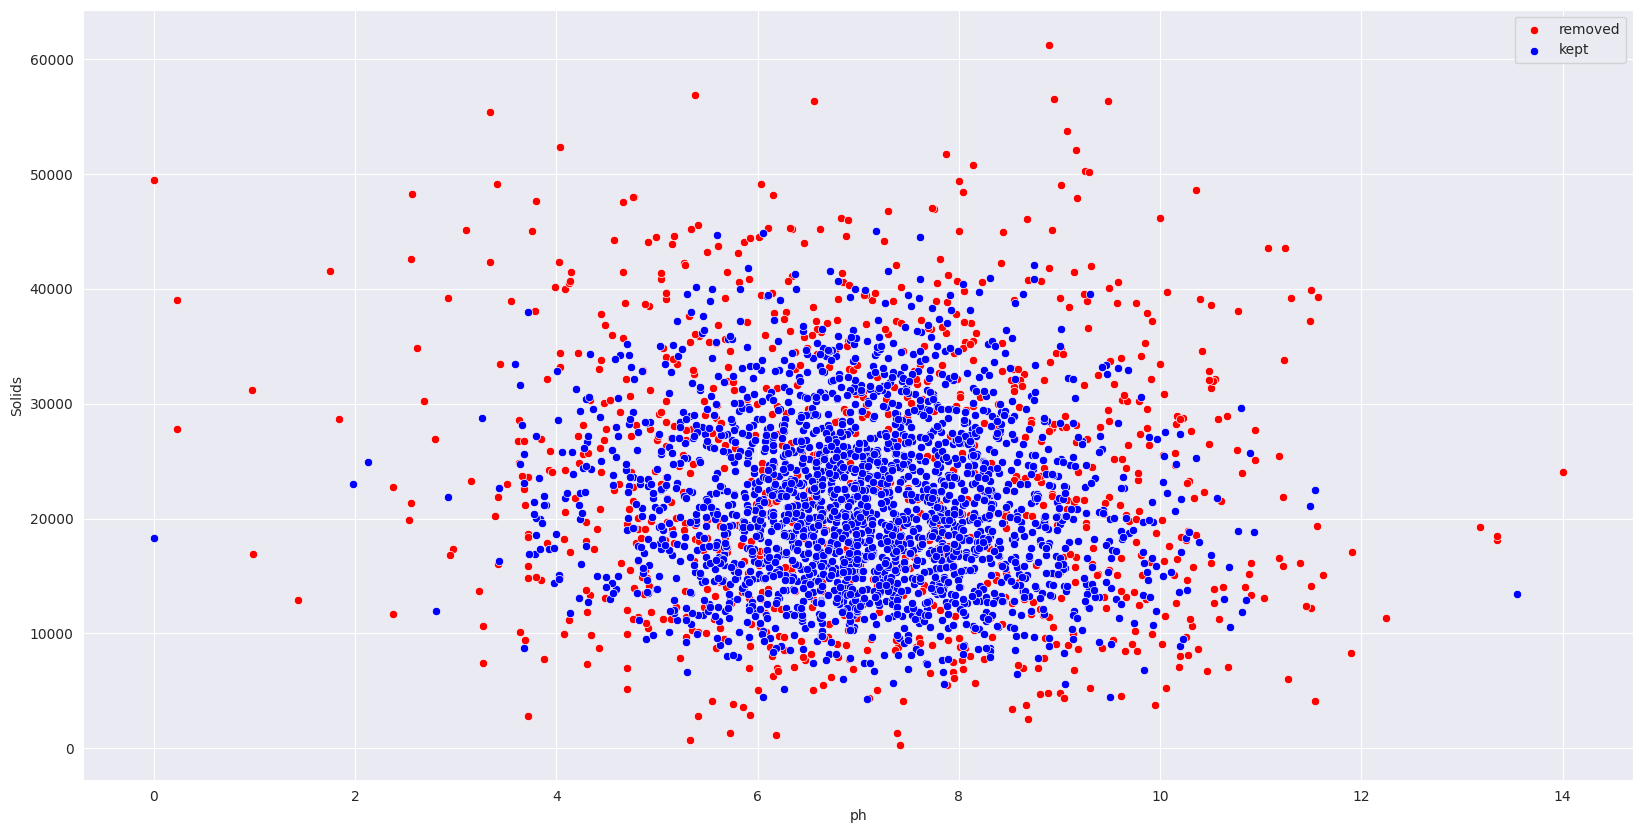

In [18]:
model = IsolationForest(contamination = 0.3)
model.fit(data_random.to_numpy())
data_random[model.predict(data_random.to_numpy()) == -1]
plt.figure(figsize= (20,10))
sns.scatterplot(data = data_random[model.predict(data_random.to_numpy()) == -1], x = "ph", y = "Solids", color = "red", label = "removed")
sns.scatterplot(data = data_random[model.predict(data_random.to_numpy()) == 1], x = "ph", y = "Solids", color = "blue", label = "kept")

Visualize boxplots. We can see compared to last boxplot we have less outliars.

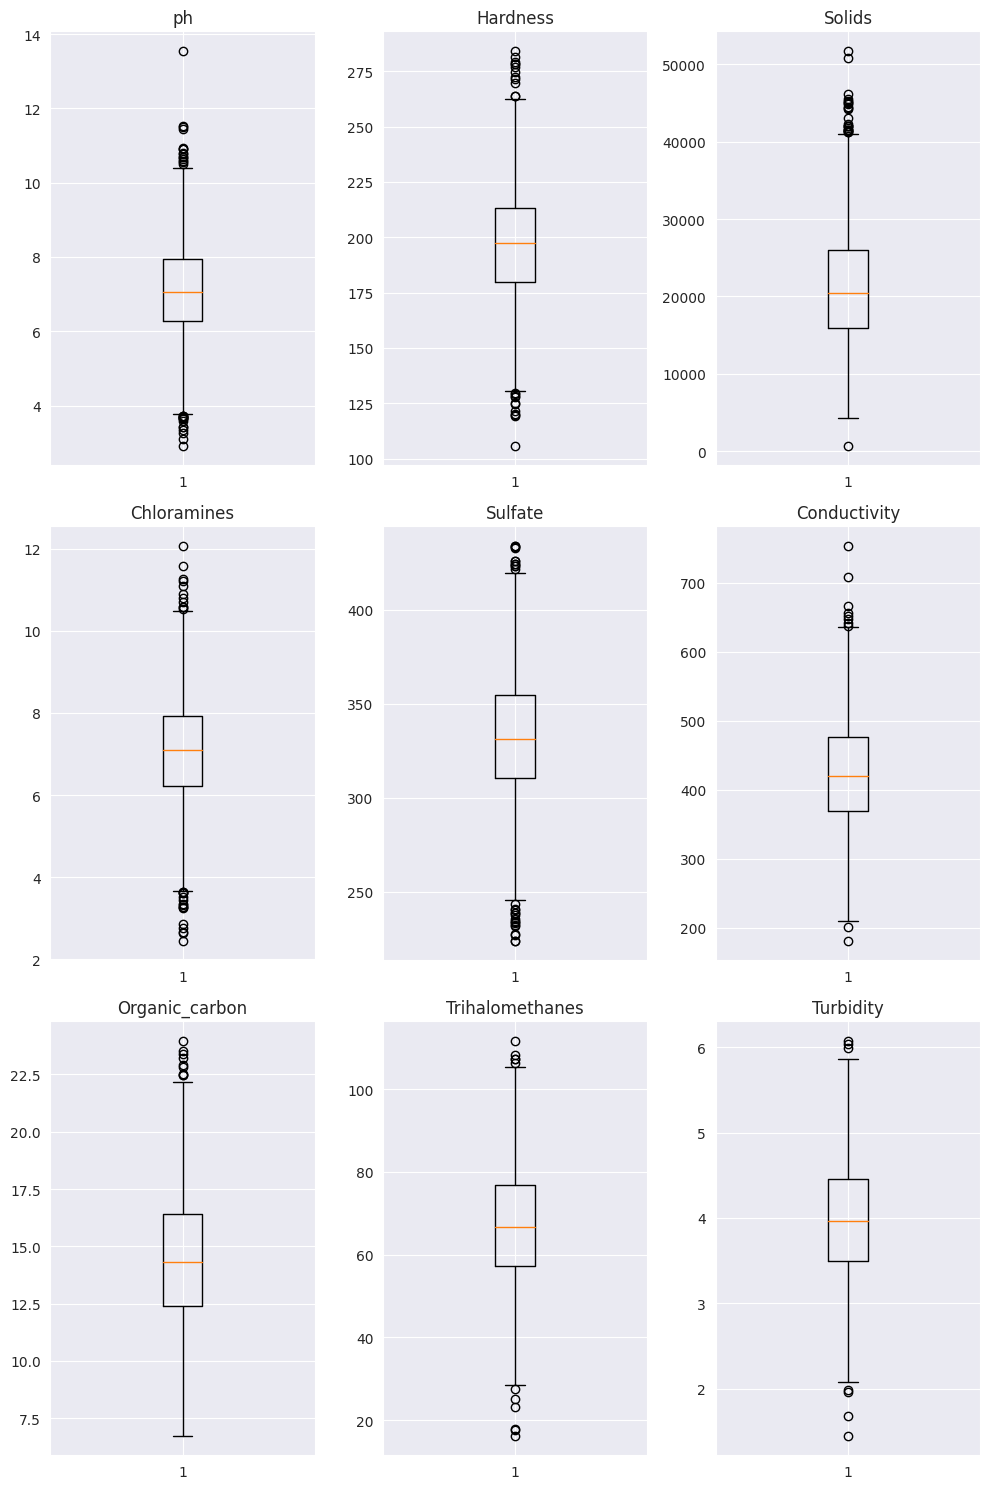

In [19]:
# We can see that there is less outliers.
show_boxplots(data_forest.columns[:-1], data_forest)

# Predictive Modeling

Because we have imbalanced data set we are going to oversample our data using SMOTE.

In [20]:
data_forest.Potability.value_counts()

Potability
0    1511
1     782
Name: count, dtype: int64

In [21]:
sm = SMOTE(random_state=42)

X, y = data_forest[data_forest.columns[:-1]], data_forest["Potability"]
X, y = sm.fit_resample(X, y)

Fitting Multiple Models with 5 fold cross validation. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
models = [RandomForestClassifier(), LogisticRegression(), AdaBoostClassifier(), KNeighborsClassifier(), QuadraticDiscriminantAnalysis(), GaussianNB(), SVC(probability=True), DecisionTreeClassifier()]
pipelines = {}
for model in models:
    model_name = str(model.__class__).split(".")[-1].split("'")[0]
    pipe = Pipeline([
        ("scaler", StandardScaler()),  # Preprocessing step
        ("classifier", model)  # Classifier step
    ])
    pipelines[model_name] = pipe


for name,pipe in pipelines.items():
    print(f"Training {name}")
    scores = cross_val_score(pipe, X_train, y_train, cv = 5, scoring = "accuracy")
    print(f"Mean Score {scores.mean()} -- Std {scores.std()} -- Min {scores.min()} -- Max {scores.max()}")


Training RandomForestClassifier
Mean Score 0.6791706781029067 -- Std 0.014739024567040794 -- Min 0.6512141280353201 -- Max 0.6909492273730684
Training LogisticRegression
Mean Score 0.5233937236825471 -- Std 0.022367199872215936 -- Min 0.5055187637969095 -- Max 0.565121412803532
Training AdaBoostClassifier
Mean Score 0.582092948624442 -- Std 0.017042630158432933 -- Min 0.5594713656387665 -- Max 0.6070640176600441
Training KNeighborsClassifier
Mean Score 0.631953399266758 -- Std 0.025829054027262023 -- Min 0.58719646799117 -- Max 0.6622516556291391
Training QuadraticDiscriminantAnalysis
Mean Score 0.6465161284048584 -- Std 0.03209461823138057 -- Min 0.5916114790286976 -- Max 0.6865342163355408
Training GaussianNB
Mean Score 0.6107720434499324 -- Std 0.043254258962590046 -- Min 0.543046357615894 -- Max 0.6754966887417219
Training SVC
Mean Score 0.658869407085412 -- Std 0.02508602701049475 -- Min 0.6136865342163356 -- Max 0.6909492273730684
Training DecisionTreeClassifier
Mean Score 0.6032

Visualizing ROC plot. From the plot and results we can see that Random Forest is the best model.

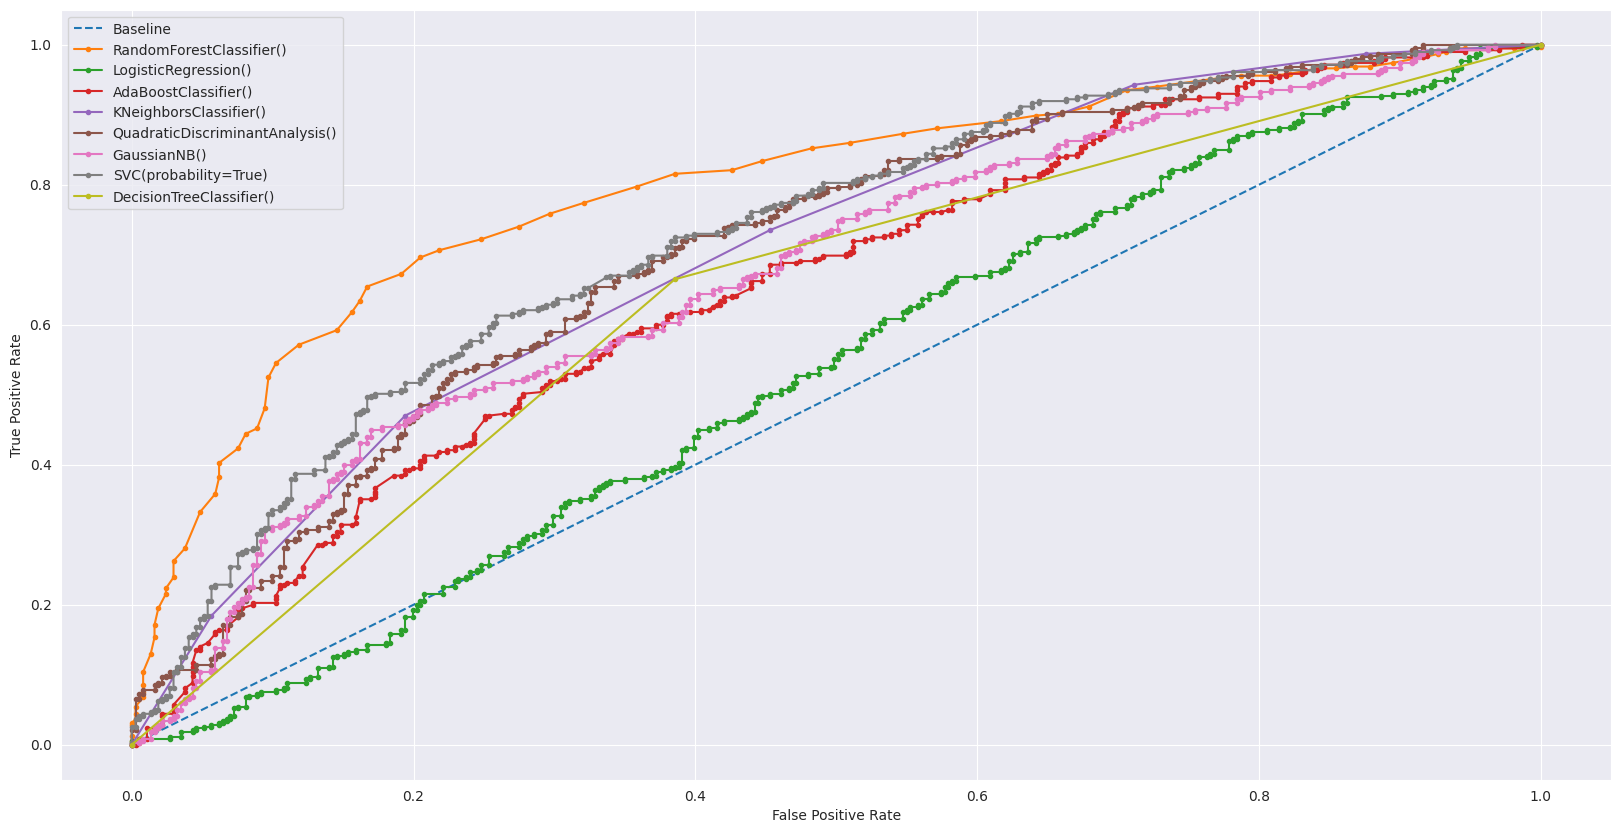

In [23]:
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
roc_plot(list(pipelines.values()), X_test, y_test)

Lets look at the feature importance of the predictors. We can see that almost all the predictors are important for the model's decision.

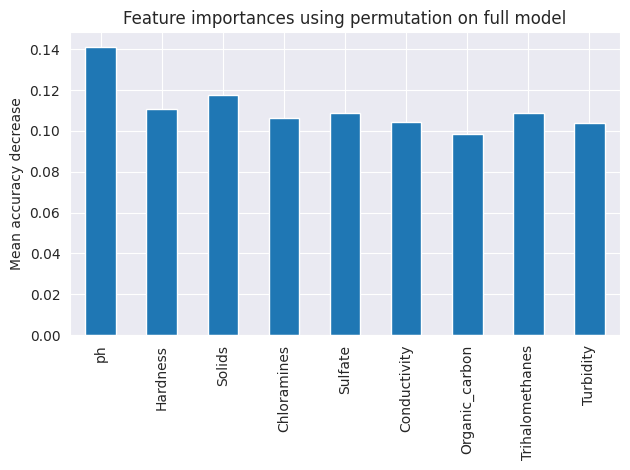

In [24]:
forest_permutation_importance(pipelines["RandomForestClassifier"]["classifier"],X_test,y_test)

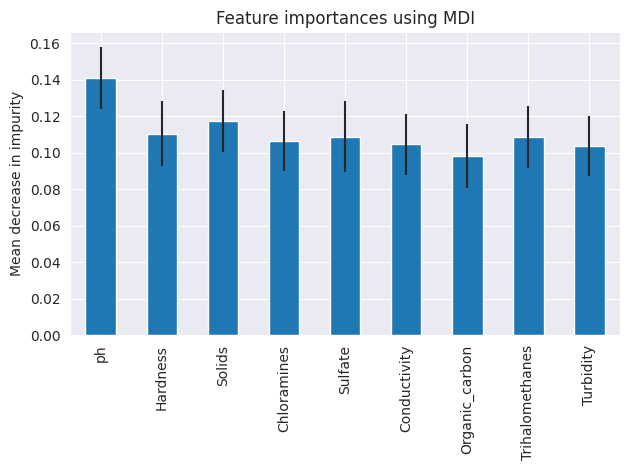

In [25]:
forest_feature_importance(pipelines["RandomForestClassifier"]["classifier"],X_test)

Hyperparameter tuning the RandomForest model.

In [26]:
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    'n_estimators': [10, 20, 30, 40,50],
    'max_depth': [5, 10, 20, 30, 50],
}

rf_classifier = RandomForestClassifier(random_state = 42)
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(
    rf_classifier, param_grid, scoring=scorer, cv=5, verbose = 1
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

best_predictions = best_rf.predict(X_test)
best_accuracy = accuracy_score(best_predictions, y_test)

print("Best Accuracy Score:", best_accuracy)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Accuracy Score: 0.7275132275132276


Hyperparameter tuning AdaBoost.

In [27]:
param_grid = {
    'n_estimators': [10, 20, 30, 40,50, 60, 70],
    "learning_rate": np.arange(0.5,1.01,0.1),
    "algorithm": ["SAMME", "SAMME.R"]

}

rf_classifier = AdaBoostClassifier()
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(
    rf_classifier, param_grid, scoring=scorer, cv=5, verbose = 1
)
grid_search.fit(X_train, y_train)
best_ada = grid_search.best_estimator_

best_predictions = best_ada.predict(X_test)
best_accuracy = accuracy_score(best_predictions, y_test)

print("Best Accuracy Score:", best_accuracy)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Accuracy Score: 0.6124338624338624


Hyperparameter tuning KNN.

In [28]:
param_grid = {
    'n_neighbors': np.arange(5,50,5),
    "leaf_size": np.arange(10,60,10),
    "weights": ["uniform", "distance"]

}

rf_classifier = KNeighborsClassifier()
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(
    rf_classifier, param_grid, scoring=scorer, cv=5, verbose = 1
)
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_

best_predictions = best_knn.predict(X_test)
best_accuracy = accuracy_score(best_predictions, y_test)

print("Best Accuracy Score:", best_accuracy)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Accuracy Score: 0.6481481481481481


In [29]:
best_rf,best_knn,best_ada

(RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=50,
                        random_state=42),
 KNeighborsClassifier(leaf_size=10, weights='distance'),
 AdaBoostClassifier(learning_rate=0.5, n_estimators=30))

Using Stacking Classifier for the last model with 5 fold cross validation.

In [30]:
estimators = [
    ('rf', RandomForestClassifier(max_depth=30, n_estimators=50)),
    ("knn", AdaBoostClassifier(learning_rate=0.89)),
    ("kn",KNeighborsClassifier(leaf_size=10, weights='distance')),
    ("q", QuadraticDiscriminantAnalysis())
]

clf = StackingClassifier(estimators= estimators, final_estimator=LogisticRegression())

scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = "accuracy")
print(f"Mean Score {scores.mean()} -- Std {scores.std()} -- Min {scores.min()} -- Max {scores.max()}")

Mean Score 0.710510449183612 -- Std 0.025517441919981274 -- Min 0.6799116997792495 -- Max 0.7505518763796909


RandomForest model outperforms the stacking model.

In [31]:
accuracy_score(best_rf.predict(X_test),y_test)

0.7275132275132276

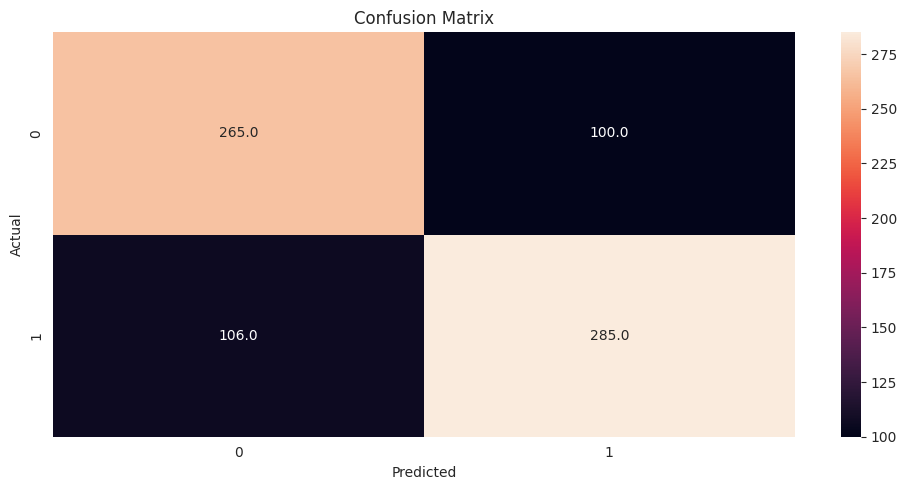

In [32]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(best_rf.predict(X_test),y_test), annot = True,fmt='.1f') 
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.tight_layout()